# Additional End of week Exercise - week 2

Now use everything you've learned from Week 2 to build a full prototype for the technical question/answerer you built in Week 1 Exercise.

This should include a Gradio UI, streaming, use of the system prompt to add expertise, and the ability to switch between models. Bonus points if you can demonstrate use of a tool!

If you feel bold, see if you can add audio input so you can talk to it, and have it respond with audio. ChatGPT or Claude can help you, or email me if you have questions.

I will publish a full solution here soon - unless someone beats me to it...

There are so many commercial applications for this, from a language tutor, to a company onboarding solution, to a companion AI to a course (like this one!) I can't wait to see your results.

In [144]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr


In [145]:
# Initialization
load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')

if openai_api_key:
    print(f"OPENAI API Key exists and begin {openai_api_key[:8]}")
else:
    print("OpenAI key not exist")

MODEL='gpt-4o-mini'
openai = OpenAI()

OPENAI API Key exists and begin sk-proj-


In [146]:
system_message = "You are a helpful assistant for an Cloths Stor called Mubarack Textails. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [147]:
def chat(messages, history):
    messages=[{'role':'system','content':system_message}]+ history +[{'role':'user', 'content':messages}]
    response=openai.chat.completions.create(model=MODEL,messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type='messages').launch()

* Running on local URL:  http://127.0.0.1:7923

To create a public link, set `share=True` in `launch()`.


In [148]:
# Let's start by making a useful function

cloths_prices = {"belt": "$80", "t-shirt": "$50", "shirt": "$100", "trousur": "$45"}

def get_cloths_price(desired_cloths):
    print(f"Tool get_cloths_price called for {desired_cloths}")
    cloth = desired_cloths.lower()
    return cloths_prices.get(cloth, "Unknown")
    

In [149]:
get_cloths_price('belt')

Tool get_cloths_price called for belt


'$80'

In [150]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_cloths_price",
    "description": "Get the price of a all cloths. Call this whenever you need to know the cloths price, for example when a customer asks 'How much is to this '",
    "parameters": {
        "type": "object",
        "properties": {
            "desired_cloths": {
                "type": "string",
                "description": "The cloth that the customer wants to know the Price",
            },
        },
        "required": ["desired_cloths"],
        "additionalProperties": False
    }
}

In [151]:
tools= [{'type':'function', 'function':price_function}]

In [152]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, cloth = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [153]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    cloth = arguments.get('desired_cloths')
    price = get_cloths_price(cloth)
    response = {
        "role": "tool",
        "content": json.dumps({"desired_cloths": cloth,"price": price}),
        "tool_call_id": message.tool_calls[0].id
    }
    return response, cloth

In [154]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7924

To create a public link, set `share=True` in `launch()`.


Tool get_cloths_price called for normal belt
Tool get_cloths_price called for black shirt
Tool get_cloths_price called for normal shirt
Tool get_cloths_price called for shirt


In [155]:
import base64
from io import BytesIO
from PIL import Image

In [156]:
def artist(cloth):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a {cloth}, showing Brand and everything unique about {cloth}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

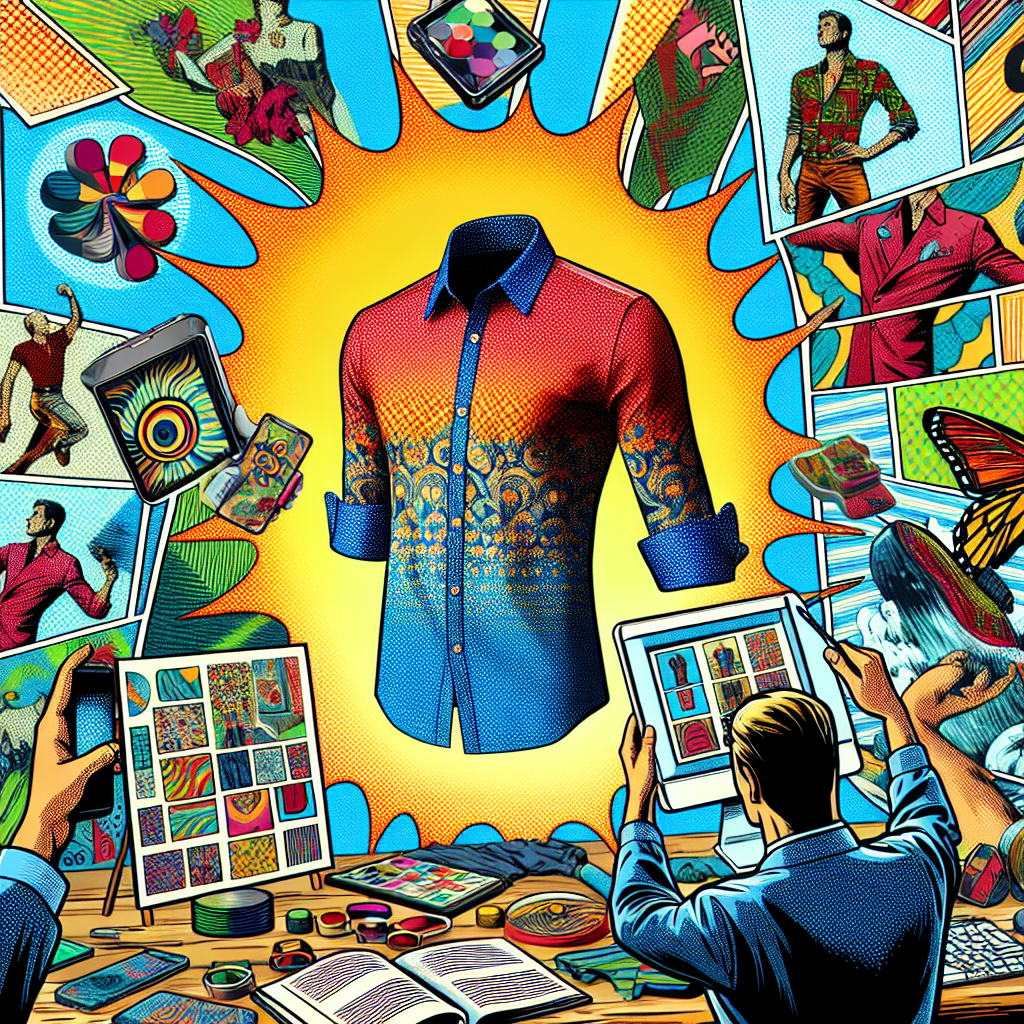

In [157]:
image = artist("Shirt")
display(image)

In [158]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="onyx",    # Also, try replacing onyx with alloy
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [159]:
talker("Well, hi there")

Input #0, wav, from '/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/tmpo3kfaebz.wav':
  Duration: 00:00:00.74, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   0.66 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

In [162]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, cloth = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(cloth)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker(reply)
    
    return history, image

In [163]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7926

To create a public link, set `share=True` in `launch()`.


Input #0, wav, from '/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/tmpnu2cp7dy.wav':
  Duration: 00:00:02.04, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   1.92 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

Input #0, wav, from '/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/tmpszf2jpsn.wav':
  Duration: 00:00:03.48, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   3.38 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

Input #0, wav, from '/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/tmpy1s_ssz3.wav':
  Duration: 00:00:02.71, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   2.61 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 


Tool get_cloths_price called for t-shirt


Input #0, wav, from '/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/tmpl69x3khk.wav':
  Duration: 00:00:04.49, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   4.38 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

Input #0, wav, from '/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/tmp2vzhu1lv.wav':
  Duration: 00:00:03.65, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   3.54 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

In [164]:

# Function to convert audio to text using OpenAI Whisper or another model
def process_audio(audio_file):
    try:
        # Check the file extension to make sure it's supported
        _, ext = os.path.splitext(audio_file)
        supported_formats = ['.flac', '.m4a', '.mp3', '.mp4', '.mpeg', '.mpga', '.oga', '.ogg', '.wav', '.webm']
        
        if ext.lower() not in supported_formats:
            raise ValueError(f"Unsupported audio file format: {ext}")
        
        # Open the audio file in binary mode
        with open(audio_file, "rb") as f:
            transcription = openai.audio.transcriptions.create(model="whisper-1", file=f)
        
        return transcription.text
    except Exception as e:
        print(f"Error in transcription: {e}")
        return "Error processing audio"

def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role": "assistant", "content": reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker(reply)
    
    return history, image

# Gradio UI setup
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
        audio_input = gr.Audio(type="filepath", label="Speak to the Assistant")  # Audio input
        submit_audio_btn = gr.Button("Submit Audio")  # Button to submit audio
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role": "user", "content": message}]
        return "", history

    # Handle audio button press
    def handle_audio_submission(audio_file, history):
        print(f"Audio file received: {audio_file}")  # Log the file path
        text_input = process_audio(audio_file)
        print(f"Transcribed text: {text_input}")  # Log the transcribed text
        history += [{"role": "user", "content": text_input}]
        return text_input, history
    
    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )

    # Handle the audio input submission using the button
    submit_audio_btn.click(
    handle_audio_submission, 
    inputs=[audio_input, chatbot], 
    outputs=[entry, chatbot]
                        ).then(
    chat, inputs=chatbot, outputs=[chatbot, image_output]
)

    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7927

To create a public link, set `share=True` in `launch()`.


Audio file received: /private/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/gradio/7a451c62843b52282f61ac5d26772fa210e5b4ef0a4a447876a004774b153c16/audio.wav
Transcribed text: Hello.


Input #0, wav, from '/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/tmphcqg5pql.wav':
  Duration: 00:00:02.04, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   1.94 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 


Audio file received: /private/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/gradio/0b4fe00d2f595d259a65c6b0f14c53c41cf9c5c4c92790cb8263f082459f783d/audio.wav
Transcribed text: I need a pen, can I get it?


Input #0, wav, from '/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/tmp1bpgr491.wav':
  Duration: 00:00:03.48, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   3.37 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 


Audio file received: /private/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/gradio/ccab541265530aaaf54dd54514f937e3151b6dd6306824ccb8a4ab2aa96817e2/audio.wav
Transcribed text: I want a shirt. Can I get it?


Input #0, wav, from '/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/tmpr883jg1c.wav':
  Duration: 00:00:04.94, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   4.82 M-A: -0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 


Audio file received: /private/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/gradio/6b326f7c16acd3f7afd707768aa4b72930678cbc6fc0e9a7cf6efd92b5d7178a/audio.wav
Transcribed text: I need a t-shirt
Tool get_cloths_price called for t-shirt


Input #0, wav, from '/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/tmp2ibm9xlq.wav':
  Duration: 00:00:04.32, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   4.23 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 


Audio file received: /private/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/gradio/04631fca11711e220a98932696aa141da052f42cbd3fa1983b6d81ab8b09426b/audio.wav
Transcribed text: Thank you, I will come and see you in the store.


Input #0, wav, from '/var/folders/3q/wljn7q7j19x5n42x07r6glth0000gn/T/tmp72wafxhj.wav':
  Duration: 00:00:02.83, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   2.77 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 